In [1]:
import numerical_tests as nt

## Introduction

Optical flow describes the apparent motion in an image sequence caused by movement in the scene or by camera motion. We model an image sequence as a function $I(x,y,t)$ and seek the flow field $w = (u,v)$ at a fixed time, where $u$ and $v$ represent the horizontal and vertical motion. Assuming that image intensities remain approximately constant along the motion, we obtain the optical flow equation
$$
u\, I_x + v\, I_y = - I_t.
$$
Since this single equation cannot uniquely determine both $u$ and $v$ (the aperture problem), we follow the classical Horn--Schunck approach and introduce a smoothness prior. This leads to the variational problem
$$
\frac12 \|u I_x + v I_y + I_t\|^2 
+ \frac{\lambda}{2}\left( \|\nabla u\|^2 + \|\nabla v\|^2 \right) \to \min,
$$
whose Euler-Lagrange equations form a coupled system of PDEs for $u$ and $v$.

For the numerical implementation, we are given two consecutive frames $I_0$ and $I_1$ on an $m \times n$ pixel grid, with $\Delta t = 1$ and pixel spacing $h_0 = 1$. The temporal derivative is approximated by
$$
I_t(x_i,y_j) \approx I_1(x_i,y_j) - I_0(x_i,y_j),
$$
and the spatial derivatives $I_x$ and $I_y$ are computed by averaging forward differences from $I_0$ and $I_1$. The flow components $u$ and $v$ are discretised on the same grid, and the Laplacian is approximated with the standard 5-point stencil
$$
(\Delta u)_{i,j} \approx 
u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4u_{i,j}.
$$
With Dirichlet boundary conditions, this yields the coupled discrete system
$$
(I_x)^2_{ij}\, u_{ij} + (I_x I_y)_{ij} \, v_{ij} 
- \lambda (\Delta u)_{i,j}
= - (I_t I_x)_{i,j},
$$
$$
\begin{equation}
(I_y)^2_{i,j}\, v_{ij} + (I_x I_y)_{ij} \, u_{i,j} 
- \lambda (\Delta v)_{i,j}
= - (I_t I_y)_{i,j},
\end{equation}
\tag{1}
$$
which we solve for $u$ and $v$.

## Defining the linear system

The system (1) can be written as a problem on the form $Ax=b$, where

$$
      \begin{bmatrix}
      D_{xx} + \lambda A_{1,1} & D_{xy} \\
      D_{xy} & D_{yy} + \lambda A_{2,2}
      \end{bmatrix}
      \begin{bmatrix}
      u\\
      v
      \end{bmatrix}
      =
      b.
$$

All matrices and vectors are of dimensions

$$
      D_{xx},\, D_{xy},\, D_{yy},\, A_{1,1}, A_{2,2} \in \mathbb{R}^{(m n) \times (m n)}, \qquad
      u,\, v \in \mathbb{R}^{m n}, \qquad
      b \in \mathbb{R}^{2 m n}.
$$

To define these matrices explicitly, note that each matrix index $i \in \{1,\dots,mn\}$ corresponds to the pixel
$$
p(i) = ((i-1) \bmod m) + 1, \qquad
q(i) = \Big\lfloor \frac{i-1}{m} \Big\rfloor + 1,
$$
so that the unknowns are ordered row by row.



The matrices $D_{xx}, D_{yy}, D_{xy}$ are diagonal because the data term only depends
on the values of $u$ and $v$ at the same pixel. Their entries are
$$
(D_{xx})_{i,j} =
\begin{cases}
(I_x)_{p(i),\,q(i)}^2, & i = j,\\[4pt]
0, & i \ne j,
\end{cases}
$$
$$
(D_{yy})_{i,j} =
\begin{cases}
(I_y)_{p(i),\,q(i)}^2, & i = j,\\[4pt]
0, & i \ne j,
\end{cases}
$$
$$
(D_{xy})_{i,j} =
\begin{cases}
(I_x)_{p(i),\,q(i)}\, (I_y)_{p(i),\,q(i)}, & i = j,\\[4pt]
0, & i \ne j.
\end{cases}
$$

The spatial derivatives are discretised using forward differences in each frame and
then averaged:
$$
\begin{aligned}
(I_x)_{p,q}
&= \tfrac{1}{2}\big[(I_0)_{p+1,q} - (I_0)_{p,q}
                  + (I_1)_{p+1,q} - (I_1)_{p,q}\big], \\[6pt]
(I_y)_{p,q}
&= \tfrac{1}{2}\big[(I_0)_{p,q+1} - (I_0)_{p,q}
                  + (I_1)_{p,q+1} - (I_1)_{p,q}\big].
\end{aligned}
$$

Depending on what boundary condition we use we get two slightly different laplace discretizations. For Dirichlet B.C we get

$$
(A_{1,1}^{dir})_{i,j} = (A_{2,2}^{dir})_{i,j} =
\begin{cases}
4, & \text{if } i=j,\\
-1, & \text{if } |i-j|=1,\\
-1, & \text{if } |i-j|=m,\\
0, & \text{otherwise.}
\end{cases}
$$

$$
A_{1,1}^{dir} = A_{2,2}^{dir} = 
\begin{bmatrix}
4 & -1 &        &        & \cdots &        & -1     &        &        \\
-1& 4  & -1     &        &        & \cdots &        & -1     &        \\
   & -1 & 4     & -1     &        &        & \cdots &        & \ddots \\
   &    & \ddots& \ddots & \ddots &        &        &        &        \\
\vdots&  &       & -1     & 4     & -1     &        &        &        \\
      & \vdots  &        &        & -1     & 4      & -1     &        &        \\
-1    &         & \cdots &        &        & -1     & 4      & -1     &        \\
      & -1      &        & \cdots &        &        & -1     & 4      & -1     \\
      &         & \ddots &        &        &        &        & -1     & 4
\end{bmatrix}.
$$

Using Neumann B.C we get the same structure for the matrix as with Dirichlet, but with different diagonal entries

$$
(A_{1,1}^{neu})_{ij} = (A_{2,2}^{neu})_{ij} =
\begin{cases}
-1, & \text{if } |i-j|=1 \text{ (horizontal neighbor)},\\[4pt]
-1, & \text{if } |i-j|=m \text{ (vertical neighbor)},\\[4pt]
d_i, & \text{if } i=j,\\[4pt]
0, & \text{otherwise,}
\end{cases}
$$

where the diagonal value depends on how many neighbors the point has

$$
d_i =
\begin{cases}
2, & i \in \{\,1,\ m,\ m(n-1)+1,\ mn\,\}, \\[6pt]
3, & i \in \{\,2,\dots,m-1\,\}
      \;\cup\; \{\,k m + 1 : k=1,\dots,n-2\,\}
      \;\cup\; \{\,m(n-1)+2,\dots,mn-1\,\}
      \;\cup\; \{\,m k : k=2,\dots,n-1\,\}, \\[6pt]
4, & \text{otherwise.}
\end{cases}
$$

Finally we have

$$
b_j =
\begin{cases}
-\, (I_t)_{p(j),\,q(j)}\, (I_x)_{p(j),\,q(j)}, & 1 \le j \le mn,\\[6pt]
-\, (I_t)_{p(j-mn),\,q(j-mn)}\, (I_y)_{p(j-mn),\,q(j-mn)}, & mn < j \le 2mn.
\end{cases}
$$


Depending on the chosen boundary conditions, we obtain two slightly different
discretisations of the Laplacian. For Dirichlet boundary conditions we get
$$
(A_{1,1}^{dir})_{i,j} = (A_{2,2}^{dir})_{i,j} =
\begin{cases}
4,  & i = j,\\
-1, & |i-j| = 1,\\
-1, & |i-j| = m,\\
0,  & \text{otherwise.}
\end{cases}
$$

A typical structure of the matrix is
$$
A_{1,1}^{dir} = A_{2,2}^{dir} =
\begin{bmatrix}
4 & -1 &        &        & \cdots &        & -1     &        &        \\
-1& 4  & -1     &        &        & \cdots &        & -1     &        \\
   & -1 & 4     & -1     &        &        & \cdots &        & \ddots \\
   &    & \ddots& \ddots & \ddots &        &        &        &        \\
\vdots& &       & -1     & 4     & -1     &        &        &        \\
      & \vdots  &        &        & -1     & 4      & -1     &        &        \\
-1    &         & \cdots &        &        & -1     & 4      & -1     &        \\
      & -1      &        & \cdots &        &        & -1     & 4      & -1     \\
      &         & \ddots &        &        &        &        & -1     & 4
\end{bmatrix}.
$$
We remark that our Laplacian matrices are defined with a positive diagonal and
negative off-diagonal entries. This corresponds to using the discrete operator
$-\Delta$ instead of $\Delta$.

For Neumann boundary conditions the sparsity pattern is the same, but the
diagonal entries differ:
$$
(A_{1,1}^{neu})_{i,j} = (A_{2,2}^{neu})_{i,j} =
\begin{cases}
-1, & |i-j| = 1 \quad \text{(horizontal neighbour)},\\[4pt]
-1, & |i-j| = m \quad \text{(vertical neighbour)},\\[4pt]
d_i, & i = j,\\[4pt]
0, & \text{otherwise.}
\end{cases}
$$

The diagonal entry $d_i$ depends on how many neighbours the pixel has:
$$
d_i =
\begin{cases}
2, & i \in \{1,\, m,\, m(n-1)+1,\, mn\} \quad \text{(corners)},\\[6pt]
3, & i \in \{2,\dots,m-1\}
      \;\cup\; \{km+1 : k=1,\dots,n-2\}
      \;\cup\; \{m(n-1)+2,\dots,mn-1\}
      \;\cup\; \{mk : k=2,\dots,n-1\} \quad \text{(edges)},\\[6pt]
4, & \text{otherwise (interior)}.
\end{cases}
$$

Finally, the right-hand side vector is
$$
b_j =
\begin{cases}
-\,(I_t)_{p(j),\,q(j)}\,(I_x)_{p(j),\,q(j)}, & 1 \le j \le mn,\\[6pt]
-\,(I_t)_{p(j-mn),\,q(j-mn)}\,(I_y)_{p(j-mn),\,q(j-mn)}, & mn < j \le 2mn.
\end{cases}
$$


## Properties of the linear system

First we check whether the system is symmetric.

$$
A^T 
=
 \begin{bmatrix}
D_{xx} + \lambda A_{1,1} & D_{xy} \\
D_{xy} & D_{yy} + \lambda A_{2,2}
\end{bmatrix}^T
= 
\begin{bmatrix}
D_{xx}^T + \lambda A_{1,1}^T & D_{xy}^T \\
D_{xy}^T & D_{yy}^T + \lambda A_{2,2}^T
\end{bmatrix}
=
\begin{bmatrix}
D_{xx} + \lambda A_{1,1} & D_{xy} \\
D_{xy} & D_{yy} + \lambda A_{2,2}
\end{bmatrix}
= A.
$$

Now we check whether the system is positive (semi-)definite. We use the split
$$
A = \lambda A_1 + A_2 =
\lambda 
\begin{bmatrix}
 A_{1,1} & 0 \\
 0 & A_{2,2}
\end{bmatrix}
+
\begin{bmatrix}
D_{xx} & D_{xy} \\
D_{xy} & D_{yy}
\end{bmatrix}.
$$

We first consider Dirichlet boundary conditions. For $A_1^{dir}$ all diagonal
entries satisfy $a_{ii}=4$, so all Gershgorin disk centres coincide. The possible
radii are $r_i\in\{2,3,4\}$. Only some of the disks reach zero, so no eigenvalue
can be equal to zero. Since $A_1^{dir}$ is symmetric with strictly positive
eigenvalues, it is positive definite.

Next we consider Neumann boundary conditions. Here each diagonal entry satisfies $a_{ii} = r_i,$ because the radius is exactly the number of neighbours of each point. In this
case all Gershgorin disks touch zero, and therefore we can only conclude that $A_1^{neu}$ is positive semi-definiteness.

The figure below shows the corresponding Gershgorin disks for both cases.


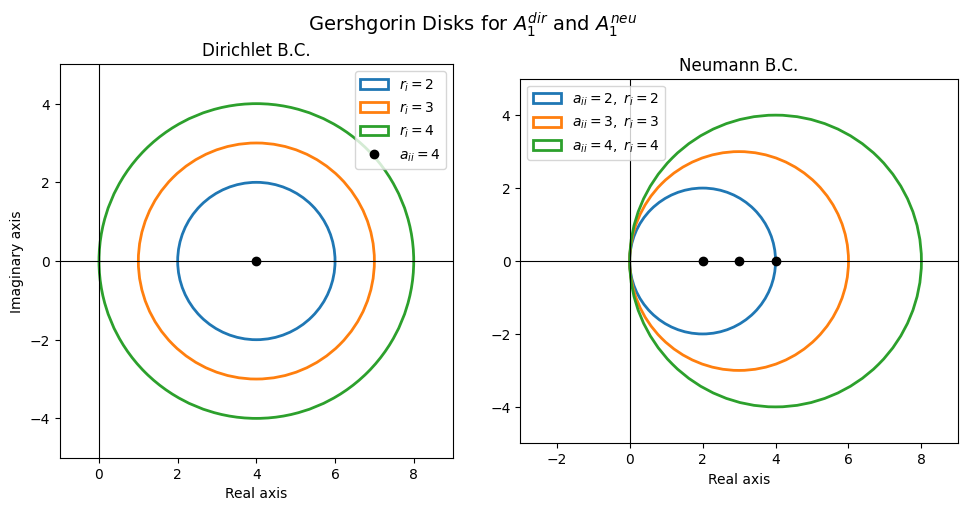

In [2]:
nt.plot_gerhsgorin_disks()

Now we look at $A_2$. This matrix is the same for both boundary conditions. For
this matrix to be diagonally dominant we would need 
$(I_x)_i^2 \ge |(I_x)_i (I_y)_i|$ and 
$(I_y)_i^2 \ge |(I_x)_i (I_y)_i|$ for all $i=1,\dots,mn$. This is only true if
$|(I_x)_i| = |(I_y)_i|$, which is generally not the case. However, this does not
exclude positive (semi-)definiteness.

For any $x \in \mathbb{R}^{2mn}$,
$$
\begin{align*}
x^T
\begin{bmatrix}
D_{xx} & D_{xy} \\
D_{yx} & D_{yy}
\end{bmatrix}
x
&=
\begin{bmatrix}
u^\top & v^\top
\end{bmatrix}
\begin{bmatrix}
D_{xx} & D_{xy} \\
D_{yx} & D_{yy}
\end{bmatrix}
\begin{bmatrix}
u \\[3pt]
v
\end{bmatrix}\\
&=
u^\top D_{xx} u 
+ u^\top D_{xy} v 
+ v^\top D_{yx} u 
+ v^\top D_{yy} v\\

&= \sum_{i=1}^{mn} (I_x)_i^2 u_i^2 
+ 2 \sum_{i=1}^{mn} (I_x)_i (I_y)_i\, u_i v_i
+ \sum_{i=1}^{mn} (I_y)_i^2 v_i^2\\
&= 
\sum_{i=1}^{mn} \big( (I_x)_i u_i + (I_y)_i v_i \big)^2 \\
&\;\ge\; 0.
\end{align*}
$$

Thus $A_2$ is positive semi-definite.

Since $A_1^{dir}$ is positive definite and $A_2$ is positive
semi-definite, we obtain for any $x \in \mathbb{R}^{2mn}$,
$$
x^T A x
= x^T (\lambda A_1^{dir} + A_2) x
= \lambda\, x^T A_1^{dir} x + x^T A_2 x
\;\ge\; \lambda\, x^T A_1^{dir} x
\;>\; 0.
$$
Thus, for Dirichlet boundary conditions the full system matrix $A$ is positive
definite.

For Neumann boundary conditions, however, $A_1^{neu}$ is only positive
semi-definite. Since $A_2$ is also positive semi-definite, we obtain for any
$x \in \mathbb{R}^{2mn}$,
$$
x^T A x
= x^T (\lambda A_1^{neu} + A_2) x
= \lambda\, x^T A_1^{neu} x + x^T A_2 x
\;\ge\; 0.
$$
Thus, for Neumann boundary conditions the full system matrix $A$ is positive
semi-definite.


## Convergence analysis

We will discuss how the properties of the matrix $A = \lambda A_1 + A_2$ influence the
behaviour of the iterative methods used in this project. From the previous analysis
we know that $A$ is symmetric in every case.

### Dirichlet boundary conditions

Under Dirichlet boundary conditions the matrix $A_1$ is positive definite and $A_2$
is positive semi definite. Hence the full matrix $A$ is symmetric positive definite.
The matrix is not diagonally dominant and diagonal dominance arguments cannot be used
for the Jacobi method or for Gauss–Seidel.

Positive definiteness and symmetry are exactly the properties required by the
Conjugate Gradient method. CG is the main solver in this project both on the fine
grid and on the coarsest grid of the multigrid hierarchy. Since $A$ is symmetric
positive definite under Dirichlet boundary conditions CG is fully applicable and its
convergence is guaranteed.

Gauss–Seidel is not used as a main solver. It is used only as a smoother inside the
multigrid V cycle. For smoothing it is important that relaxation behaves in a stable
way and the positive definiteness of $A$ ensures that Gauss–Seidel provides effective
smoothing steps.

The Jacobi method is not guaranteed to converge. Jacobi works for the pure Laplacian
with Dirichlet boundary conditions but the additional terms in $A_2$ destroy diagonal
dominance. For the full operator Jacobi may converge very slowly or fail to converge.
For this reason Jacobi is used only as an optional smoother and never as the main
solver.

### Neumann boundary conditions

Under Neumann boundary conditions the matrix $A_1$ is positive semi definite and has
constant vectors in its kernel. Since $A_2$ is also positive semi definite the full
matrix $A = \lambda A_1 + A_2$ is in general positive semi definite as well. The
matrix becomes positive definite only if the term $A_2$ removes the constant
nullspace. If this does not happen the PDE may have a non unique solution or no
solution.

If the matrix remains singular then CG cannot be used since CG requires symmetry and
positive definiteness. Gauss–Seidel may also fail in this situation. Jacobi again has
no general guarantee of convergence since the matrix is not diagonally dominant.

The project uses Dirichlet boundary conditions and the system is therefore positive
definite. The iterative solvers used here are consequently well defined and
convergent.


## Numerical tests

In this section we study the behaviour of three numerical methods for the optical
flow problem. We compare the Conjugate Gradient method (CG) the multigrid V-cycle (MG)
and the preconditioned Conjugate Gradient method (PCG). All computations use Dirichlet
boundary conditions and the convergence criterion $\lVert r_k \rVert_2 \, / \, \lVert r_0 \rVert_2 < 10^{-8}$ where $r_k$ denotes the residual after iteration $k$.

For the synthetic test cases we follow the project specification and choose the
regularisation parameter according to the rule $\lambda_k = 4^{k-4}$ where $N=2^k$ and $(N\times N)$ is the image size. The influence of the parameter $\lambda$ is investigated separately in the end.

### Conjugate Gradient method

We begin by testing the CG on the synthetic examples in order to verify correctness and study how the method behaves for increasing grid sizes. The first test case consists of a single Gaussian that moves diagonally between the two frames. This example has a simple and almost constant motion in the central region and vanishing motion near the boundary due to the Dirichlet conditions. This makes it suitable for checking that the implementation produces the expected flow pattern before analysing convergence behaviour.

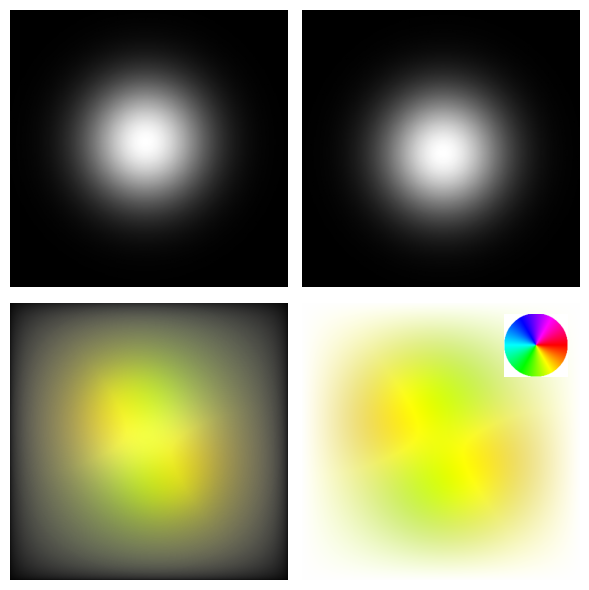

In [3]:
nt.plot_method_solution(N=256, testcase=1, method="CG")

The flow field produced by the CG method correctly captures the diagonal movement of the Gaussian in the central region of the image. As expected the motion decreases towards the boundary where the Dirichlet conditions force the velocity to zero. The resulting vector field is smooth across the domain and matches the qualitative behaviour of the true motion. This confirms that the implementation of the linear system and the CG solver is correct and behaves as expected for this test case.

Now we examine the convergence behaviour of the CG method for different grid sizes.
For this purpose we use the second synthetic test case with the two circling Gaussians
and run the CG solver on images of size $N = 2^k$ with $k = 6 \dots 9$. We follow the
project specification and choose the regularisation parameter $\lambda_k = 4^{k-4}$.
For each resolution we record the residual histories and the total computation times.
The corresponding convergence curves are shown below.

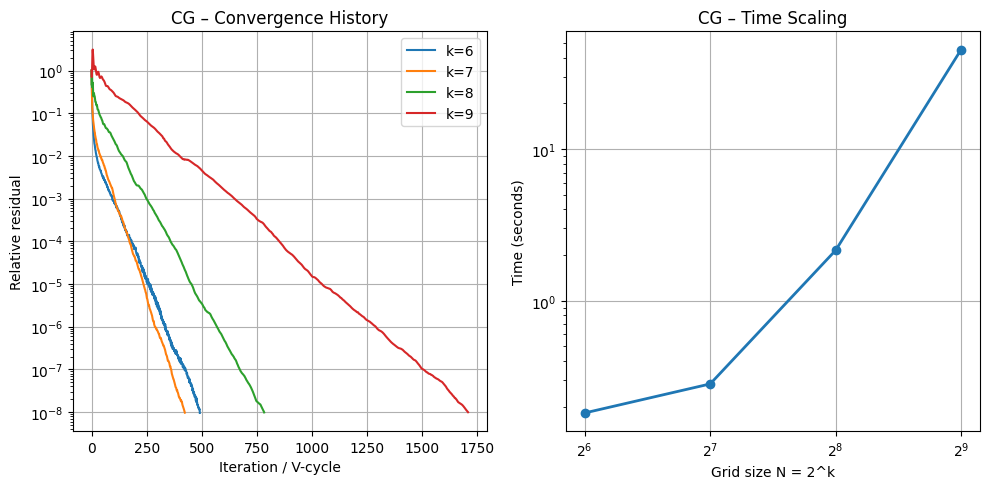

In [4]:
ks = [6,7,8,9]
results_CG = nt.run_single_method("CG", ks, testcase=2)
nt.plot_method_summary(ks, results_CG, method="CG")

The CG method converges for all resolutions $N = 2^k$, $k = 6,\dots,9$, and reaches the required tolerance. The convergence curves for $k = 6,7,8$ are smooth, while the curve for $k = 9$ shows a brief irregularity in the first few iterations. This kind of non-monotonic behaviour can occur while the Krylov space is being constructed and does not indicate instability. After this initial phase, the residual decreases steadily for all grid sizes.

The number of iterations generally increases with $k$. A small exception occurs at $k=7$, where the iteration count is slightly lower than for $k=6$. Such fluctuations are normal, since the effective conditioning of the system depends not only on the grid spacing but also on the structure of the image derivatives at each resolution. The overall trend, however, is clear. Larger grids require more iterations. This matches the theoretical behaviour for elliptic PDE-like problems, where the condition number grows proportionally to $N^2$, leading to an iteration count that increases approximately linearly with $N$.

The computation time grows much faster than the iteration count. Each iteration involves operations on all $N^2$ pixels, so the total time scales roughly like $\text{time} \sim (\text{iterations}) \times N^2.$
This leads to a sharp rise in runtime from $k=6$ to $k=9$, even in cases where the increase in iteration count is modest. Overall, CG remains robust and consistent across all problem sizes, but its computational cost grows rapidly with grid resolution, which makes it less suitable for large images without preconditioning.

## Multigrid V-cycle

We now test MG on the synthetic data using the second test case. This example
contains two Gaussians moving on circular trajectories and provides a more challenging
motion field than the first test case. It is therefore well suited for checking that
smoothing, restriction, prolongation and the coarse grid solve are working correctly.

The flow field computed by MG reproduces the circular movement in the interior of the
image and smoothly decreases towards the boundary due to the Dirichlet conditions.
The result matches the expected motion and confirms that the MG implementation
produces a correct solution for this more difficult test case.

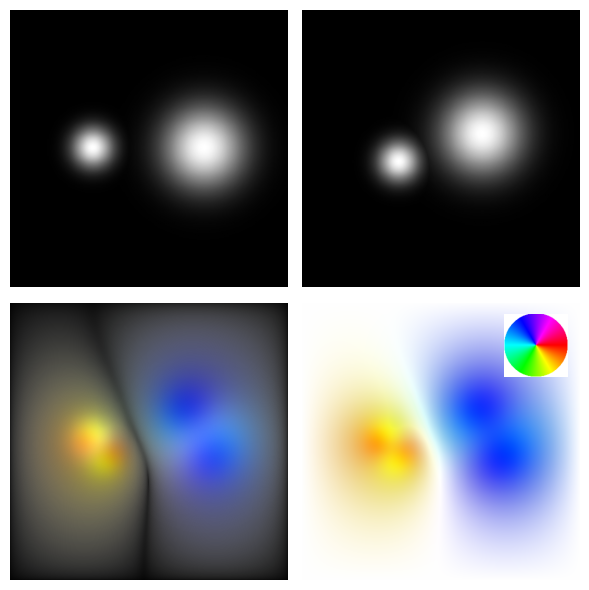

In [5]:
nt.plot_method_solution(N=256, testcase=2, method="MG", mg_s1=2, mg_s2=2, mg_max_level=2)

We next study how the MG parameters influence the behaviour of the method. The main
parameters are the number of levels $L$ and the number of smoothing steps $s_1$ and
$s_2$ in the pre and post smoothing stages. To analyse this we run MG on the second
test case for several values of $L$ and for a wide range of smoothing parameters.

The heatmaps for $k = 6$ and $k = 7$ show the number of V cycles, the total runtime
and the MG convergence factor $\rho$ for different combinations of $L$ and the total
smoothing count $s = s_1 + s_2$. The factor $\rho$ measures the average reduction of
the residual per V cycle, computed as
$\rho = (\lVert r_m \rVert_2 \,/\, \lVert r_0 \rVert_2)^{1/m}$,
where $m$ is the number of cycles. Smaller values of $\rho$ indicate faster
convergence. Since different choices of $(s_1, s_2)$ that give the same total smoothing
$s = s_1 + s_2$ show very similar behaviour, the heatmaps are organised by the total
smoothing count $s$. For each value of $s$ the result from one representative
$(s_1, s_2)$ pair is shown. We analyse the separate influence of $s_1$ and $s_2$
later.

In [ ]:
levels = [2, 3, 4]
smooth_vals = [1, 2, 3, 4, 5]


results_6 = nt.mg_parameter_sweep(k=8, testcase=2, levels=levels, smooth_vals=smooth_vals, tol=1e-8, max_cycles=200)
Svals_6, rho_mat_6, time_mat_6 = nt.results_to_matrices(results_6, levels, smooth_vals)
nt.plot_mg_heatmaps(levels, Svals_6, rho_mat_6, time_mat_6, method="MG", k=6, testcase=2)


results_7 = nt.mg_parameter_sweep(k=7, testcase=2, levels=levels, smooth_vals=smooth_vals, tol=1e-8, max_cycles=50)
Svals_7,  rho_mat_7, time_mat_7 = nt.results_to_matrices(results_7, levels, smooth_vals)
nt.plot_mg_heatmaps(levels, Svals_7, rho_mat_7, time_mat_7, method="MG", k=7, testcase=2)

The results show that the total smoothing count $s$ has a strong influence on the
behaviour of MG. Larger values of $s$ lead to smaller convergence factors $\rho$ and
fewer V cycles. Since each smoothing step is inexpensive this also reduces the total
runtime. For $k = 6$ the pattern is not perfectly monotone and the values of $\rho$
can jump slightly up and down, but the overall trend is the same: more smoothing
gives faster convergence. For $k = 7$ the behaviour is clearer and $\rho$ improves
consistently as $s$ increases.

The depth $L$ of the multigrid hierarchy also matters. Increasing $L$ allows error
components to be reduced more efficiently on coarse grids, which lowers the runtime.
However the reduction of the residual per cycle can become slightly slower for large
$L$ because the coarse grid problems are very small and the overhead from restriction
and prolongation increases. A moderate depth gives the best balance and in our tests
$L = 3$ performs well across all grid sizes.

To study the influence of the pre and post smoothing separately we test the case
$k = 7$ with both $L = 2$ and $L = 3$ while varying $s_1$ and $s_2$ independently.

In [ ]:
results_L2 = [r for r in results_7 if r["L"] == 2]
svals_2, rho_mat_2, time_mat_2 = nt.results_to_s1s2_matrices(results_L2, smooth_vals=[1,2,3,4,5])
nt.plot_s1s2_heatmaps(svals_2, rho_mat_2, time_mat_2, L=3, method="MG", k=7, testcase=2)

results_L3 = [r for r in results_7 if r["L"] == 3]
svals_3, rho_mat_3, time_mat_3 = nt.results_to_s1s2_matrices(results_L3, smooth_vals=[1,2,3,4,5])
nt.plot_s1s2_heatmaps(svals_3, rho_mat_3, time_mat_3, L=3, method="MG", k=7, testcase=2)

With only two levels MG is more sensitive to the exact choice of $(s_1, s_2)$ and the
performance varies noticeably across the parameter range. With three levels the method
becomes much more robust and converges quickly for almost all choices. Balanced
smoothing with $s_1 = s_2$ gives the most stable performance and the optimal choice is
around five smoothing steps per stage. Larger values such as $s = 8$ or $s = 10$ also
work well on coarser grids, but on finer grids the runtime increases again for $L = 2$.
This makes the combination $s_1 = s_2 = 5$ and $L = 3$ a good overall choice.

We now examine the convergence behaviour of MG for different grid sizes, using $s_1 = s_2 = 5$ and $L = 3$.

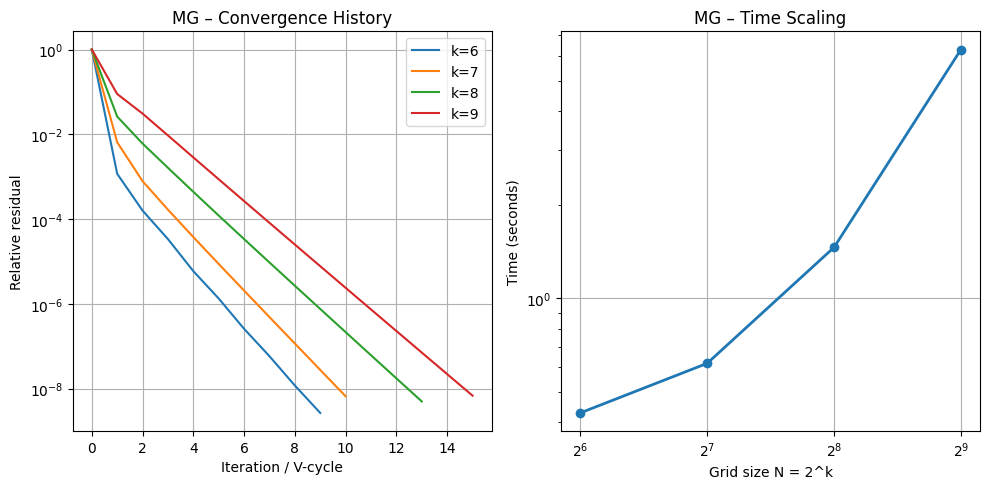

In [7]:
results_MG = nt.run_single_method("MG", ks, testcase=1, mg_s1=5, mg_s2=5, mg_max_level=3)
nt.plot_method_summary(ks, results_MG, method="MG")

The convergence curves show that the number of V cycles grows slowly with the resolution.
For $k = 6$ the method requires six cycles, and for each increase in $k$ the number of
cycles grows by roughly two. This is in strong contrast to CG, where the iteration
count increases much faster with the grid size. The runtime plot confirms this: in
logarithmic scale the MG timings grow almost linearly with $N$, with a slightly
steeper slope due to the work in the smoothing and transfer operations. Overall the
increase in computation time is much slower than for CG, making MG significantly more
scalable for large images.

## PCG
We now modify the CG solver to use MG as a preconditioner and obtain a PCG method.
In each PCG iteration we do not solve the system $Mz = r$ exactly. Instead we apply
a single MG V cycle with right hand side $r$ and use the result as an approximation
of $z$. The parameters of the MG preconditioner are taken from the previous tests,
with a fixed choice of $L$ and smoothing steps $s_1$ and $s_2$.

For PCG it is important that the preconditioner satisfies certain properties. The
operator $M$ must be symmetric, positive definite and linear, and it must be the
same in every iteration. In our case this means that one application of the MG
V cycle has to act like a fixed symmetric positive definite operator. This is
ensured by keeping the MG setup unchanged in all iterations and by using a symmetric
smoother with the same number of pre and post smoothing steps. With this choice the
V cycle can safely be used as a preconditioner for CG.

Now we study how the MG parameters influence the behaviour of the PCG. The heatmaps is for $k = 7$ and $k = 8$.

In [ ]:
levels = [2, 3, 4]
smooth_vals = [1, 2, 3, 4, 5]

results_6 = nt.mg_parameter_sweep(k=7, testcase=2, levels=levels, smooth_vals=smooth_vals, tol=1e-8, max_cycles=200)
Svals_6, rho_mat_6, time_mat_6 = nt.results_to_matrices(results_6, levels, smooth_vals)
nt.plot_mg_heatmaps(levels, Svals_6, rho_mat_6, time_mat_6, method="PCG", k=6, testcase=2)

results_7 = nt.mg_parameter_sweep(k=8, testcase=2, levels=levels, smooth_vals=smooth_vals, tol=1e-8, max_cycles=200)
Svals_7,  rho_mat_7, time_mat_7 = nt.results_to_matrices(results_7, levels, smooth_vals)
nt.plot_mg_heatmaps(levels, Svals_7, rho_mat_7, time_mat_7, method="PCG", k=7, testcase=2)

The results show that here also the total smoothing count $s$ has a strong influence on the
behaviour of PCG. Larger values of $s$ lead to smaller convergence factors $\rho$ and
fewer iterations. Since each smoothing step is inexpensive this also reduces the total
runtime. However, the time reduction is only evident in the beginning and then there is little to none improvement for the bigger $s$. It is also a clear pattern between the number of levels. Larger $L$ makes the convergence factor bigger, leading to more steps taken before convergence.

To study the influence of the pre and post smoothing separately we test the case
$k = 7$ with both $L = 2$ and $L = 3$ while varying $s_1$ and $s_2$ independently.

In [ ]:
results_L2 = [r for r in results_7 if r["L"] == 2]
svals_2, rho_mat_2, time_mat_2 = nt.results_to_s1s2_matrices(results_L2, smooth_vals=[1,2,3,4,5])
nt.plot_s1s2_heatmaps(svals_2, rho_mat_2, time_mat_2, L=2, method="MG", k=7, testcase=2)

results_L3 = [r for r in results_7 if r["L"] == 3]
svals_3, rho_mat_3, time_mat_3 = nt.results_to_s1s2_matrices(results_L3, smooth_vals=[1,2,3,4,5])
nt.plot_s1s2_heatmaps(svals_3, rho_mat_3, time_mat_3, L=3, method="MG", k=7, testcase=2)

The convergence factor keeps the same pattern as MG, where the total number of smootings is the importance for convergence factor. For convergence time there is no clear pattern for $L=2$. For $L=3$ there seems to be much less variation. The main pattern is still that more smoothing is faster.

Based on the analysis we choose the same parameter as for the MG. That is  $s_1 = s_2 = 5$ and $L = 3$. Next we test PCG on the second synthetic example for image sizes $N = 2^k$ with
$k = 6 \dots 9$, using the same regularisation parameter $\lambda_k = 4^{k-4}$ as
before.

In [ ]:
ks = [6,7,8,9]

results_PCG = nt.run_single_method("PCG", ks, testcase=2, mg_s1=5, mg_s2=5, mg_max_level=3)
nt.plot_method_summary(ks, results_PCG, method="PCG")

The convergence plots show that the number of PCG iterations is very small
for all grid sizes. Interestingly the case $k = 6$ requires the most iterations with
nine steps, while the larger grids need only six or seven iterations. This kind of
behaviour is reasonable since the effectiveness of the preconditioner depends on the
interaction between the grid hierarchy and the image structure. On very small grids
the coarse levels become tiny and the MG preconditioner is less well balanced. As the
grid size increases the V cycle becomes more effective and the number of PCG
iterations stabilises.

In terms of runtime PCG is clearly faster than plain CG. The total number of
iterations is reduced by a large factor and the extra cost of applying the MG
preconditioner in each step is compensated by the much faster convergence. The
timings grow only moderately with $N$ and remain close to those of MG used as a
standalone solver. With the choice $s_1 = s_2 = 5$ and $L = 3$ the PCG method gives a
good compromise between robustness, convergence speed and computational cost.

### Comparison of the three methods

We now compare CG, MG and PCG directly. For each method we plot the convergence
curves for all grid sizes $k = 6 \dots 9$ and finally compare the total runtime.

In [ ]:
nt.plot_all_methods_summary(ks, results_CG, results_PCG, results_MG)

The CG method shows the strongest dependence on the grid size. The number of
iterations increases clearly with $k$, and the convergence curves become flatter as
the resolution grows. This is expected since the condition number of the system
scales like $N^2$, so plain CG slows down significantly on finer grids.

MG behaves very differently. The number of V cycles grows only slowly with the grid
size, and the convergence curves for different $k$ lie close to each other. Each grid
refinement adds only a small number of additional cycles. This demonstrates the usual
multigrid property that the convergence rate is almost independent of $N$.

PCG combines the strengths of both approaches. Its iteration count is not only small
but also extremely stable. For all grid sizes it stays between six and nine
iterations, making PCG the method with the least variation in iteration numbers. The
convergence is much faster than plain CG and only slightly slower than MG. The total
runtime of PCG is very close to that of MG, since the slightly more expensive
preconditioner is balanced by the very small and nearly constant number of
iterations.

The final runtime comparison illustrates the difference between the methods. CG has
the steepest increase in computation time and becomes expensive even for moderate
resolutions. MG and PCG both scale much more favourably, and their runtimes grow only
slowly with $N$. In our tests the runtimes of MG and PCG are almost identical. However, PCG achieves nearly the same efficiency and exhibits the
most stable iteration count.

In [ ]:
nt.plot_flow_row(results_PCG, ks, method="PCG", testcase=2, title="PCG Optical Flow Fields")

## Real images with varied regularization

We now apply the three numerical methods to real image data. In this part we use the
frames *frame10.png* and *frame11.png* from the course webpage. Real images contain
noise, sharp edges and illumination variations, so the numerical derivatives benefit
from a small amount of smoothing. We therefore test the effect of applying a light
Gaussian filter before computing the derivatives and compare the results with the
unfiltered version.

The flow fields obtained with and without Gaussian smoothing are shown below. The
filtered version produces smoother derivatives and a cleaner and more coherent flow
field, while the unfiltered version shows small irregularities caused by noise. This
confirms that a light smoothing step improves the stability of the method on real
data without removing relevant motion information.

In [ ]:
nt.plot_method_solution_real(
    method="PCG",
    reg=1,
    sigma1=0,
    sigma2=1,
    mg_s1=5,
    mg_s2=5,
    mg_max_level=2
)

With this preprocessing in place we now investigate how the choice of the
regularisation parameter $\lambda$ influences the convergence behaviour and the
computation time of CG, MG and PCG. All tests are done using $\lambda \in \{0.1, 1, 10, 100, 1000\}$.

### Conjugate Gradient

We first examine how the regularisation parameter $\lambda$ influences the behaviour
of the Conjugate Gradient method. For this experiment we use the real image pair,
apply the preprocessing described above and solve the optical flow system for the
differen $\lambda$-values. For each value of $\lambda$ we record the number of CG iterations and the total runtime required to reach the convergence tolerance.

The plots below show the CG iteration count and the computation time as functions of $\lambda$.

In [ ]:
regs = [0.1, 1, 10, 100, 1000]
regs_results_pcg = nt.run_single_method_regs(method="CG", regs=regs, mg_s1=5, mg_s2=5, mg_max_level=3, from_file=False, sigma=1)
nt.plot_method_summary_regs(regs, regs_results_pcg, method="CG")

The results show a clear dependence on $\lambda$. Recall that the system matrix has
the form $A = \lambda A_1 + A_2$, where $A_1$ is the Laplacian part and $A_2$ contains the image–dependent data terms. For small $\lambda$ the contribution from $A_2$ dominates and CG converges relatively
quickly. As $\lambda$ increases the term $\lambda A_1$ becomes the main component of
$A$. Since the Laplacian is a stiff operator with a condition number that grows like
$N^2$, scaling it by $\lambda$ makes the system increasingly ill-conditioned.

This directly explains the observed behaviour. Larger $\lambda$ leads to slower CG
convergence and a rapidly increasing iteration count. The runtime follows the same
trend, as each iteration has the same computational cost. Overall, CG is very
sensitive to $\lambda$ and becomes inefficient for strongly regularised problems.

### Multigrid V-cycle

We now study how the regularisation parameter $\lambda$ affects the behaviour of the
multigrid method on the real image pair. Using the same preprocessing and Gaussian
filter as before, we solve the optical flow system for the values $\lambda \in \{0.1, 1, 10, 100, 1000, 10000\}$.  
For each value we run the MG solver with the parameter choice $L = 3$ and $s_1 = s_2 = 5$, which previously gave the best performance on the synthetic data.

In [ ]:
regs = [0.1, 1, 10, 100, 1000]
results_mg_L4 = nt.run_single_method_regs(method="MG", regs=regs, mg_s1=5, mg_s2=5, mg_max_level=4, sigma=1)
results_mg_L3 = nt.run_single_method_regs(method="MG", regs=regs, mg_s1=5, mg_s2=5, mg_max_level=3, sigma=1)
results_mg_L2 = nt.run_single_method_regs(method="MG", regs=regs, mg_s1=5, mg_s2=5, mg_max_level=2, sigma=1)
method_results_mg_L = {"L4": results_mg_L4, "L3": results_mg_L3, "L2": results_mg_L2,}
method_params_mg_L = {"L4": (5, 5, 4),  "L3":  (5, 5, 3),"L2":  (5, 5, 2),} # (s1, s2, L)
nt.plot_compare_methods_regs(method_results_mg_L, method_params_mg_L)

In [ ]:
regs = [0.1, 1, 10, 100, 1000]
results_mg_s5 = nt.run_single_method_regs(method="MG", regs=regs, mg_s1=5, mg_s2=5, mg_max_level=2, sigma=1)
results_mg_s4 = nt.run_single_method_regs(method="MG", regs=regs, mg_s1=4, mg_s2=4, mg_max_level=2, sigma=1)
results_mg_s3 = nt.run_single_method_regs(method="MG", regs=regs, mg_s1=3, mg_s2=3, mg_max_level=2, sigma=1)
results_mg_s2 = nt.run_single_method_regs(method="MG", regs=regs, mg_s1=2, mg_s2=2, mg_max_level=2, sigma=1)
method_results_mg_s = {"s5": results_mg_s5, "s4": results_mg_s4, "s3": results_mg_s3, "s2": results_mg_s2,}
method_params_mg_s = {"s5": (5, 5, 2),  "s4":  (4, 4, 2),"s3":  (3, 3, 2),"s2":  (2, 2, 2),} # (s1, s2, L)
nt.plot_compare_methods_regs(method_results_mg_s, method_params_mg_s)

For the values $\lambda \in \{0.1, 1, 10\}$ the multigrid method diverges almost
immediately on the real image pair. When $\lambda = 100$ and $\lambda = 1000$ the
behaviour changes slightly: the residual initially decreases for a few V cycles,
suggesting that some error components are reduced correctly, but after this short
phase the method becomes unstable and the residual starts to increase again. For
$\lambda = 10000$ the same pattern appears: an early reduction followed by a clear
divergence. Only for an extremely large regularisation, $\lambda = 10^6$, does the
method converge fully.

This behaviour is consistent with the structure of the system matrix $A = \lambda A_1 + A_2$. The Laplacian part $A_1$ has smooth coefficients and is ideal for MG, while the data
term $A_2$ contains $(I_x, I_y)$ and is highly irregular for real images, even after
Gaussian smoothing. When $\lambda$ is small, $A_2$ dominates and the operator is far
from elliptic; coarse-grid correction fails and MG diverges immediately. As $\lambda$
increases the system becomes a mixture of a smooth term $(\lambda A_1)$ and an
irregular term $(A_2)$. In this intermediate regime the coarse-grid correction may
accidentally improve some components at first, which explains the initial decrease
in the residual, but the instability of the coefficient structure eventually takes
over and the method diverges.

Only when $\lambda$ is extremely large does the term $\lambda A_1$ completely dominate
so that $A$ behaves almost like a pure Laplacian. In this extreme case the influence
of $A_2$ becomes negligible, the problem regains an elliptic structure, and the MG
method converges reliably.

In summary MG is not robust with respect to $\lambda$ on real images. For moderate
regularisation the early behaviour may suggest partial convergence, but the method
is ultimately unstable, and only unrealistically large values of $\lambda$ produce a
matrix that is suitable for multigrid.


### PCG



In [ ]:
results_pcg_L4 = nt.run_single_method_regs(method="PCG", regs=regs, mg_s1=5, mg_s2=5, mg_max_level=4, sigma=1)
results_pcg_L3 = nt.run_single_method_regs(method="PCG", regs=regs, mg_s1=5, mg_s2=5, mg_max_level=3, sigma=1)
results_pcg_L2 = nt.run_single_method_regs(method="PCG", regs=regs, mg_s1=5, mg_s2=5, mg_max_level=2, sigma=1)
method_results_pcg_L = {"L4": results_pcg_L4, "L3": results_pcg_L3, "L2": results_pcg_L2,}
method_params_pcg_L = {"L4": (5, 5, 4),  "L3":  (5, 5, 3),"L2":  (5, 5, 2),} # (s1, s2, L)
nt.plot_compare_methods_regs(method_results_pcg_L, method_params_pcg_L)

In [ ]:
results_pcg_s5 = nt.run_single_method_regs(method="PCG", regs=regs, mg_s1=5, mg_s2=5, mg_max_level=2, sigma=1)
results_pcg_s4 = nt.run_single_method_regs(method="PCG", regs=regs, mg_s1=4, mg_s2=4, mg_max_level=2, sigma=1)
results_pcg_s3 = nt.run_single_method_regs(method="PCG", regs=regs, mg_s1=3, mg_s2=3, mg_max_level=2, sigma=1)
results_pcg_s2 = nt.run_single_method_regs(method="PCG", regs=regs, mg_s1=2, mg_s2=2, mg_max_level=2, sigma=1)

method_results_pcg_s = {"s5": results_pcg_s5, "s4": results_pcg_s4, "s3": results_pcg_s3, "s2": results_pcg_s2,}
method_params_pcg_s = {"s5": (5, 5, 2),  "s4":  (4, 4, 2),"s3":  (3, 3, 2),"s2":  (2, 2, 2),} # (s1, s2, L)
nt.plot_compare_methods_regs(method_results_pcg_s, method_params_pcg_s)

In [ ]:
nt.plot_color_flow_row_regs(regs, method="PCG", N=480, testcase=3, mg_s1=5, mg_s2=5, mg_max_level=2, title="PCG flow fields for different λ")